In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader, random_split
from networks import Model
from dropout import *

from data import generate_data
from train import train_main_model, train_deup
from utils import inv_sigmoid, evaluate_and_plot, eval_error

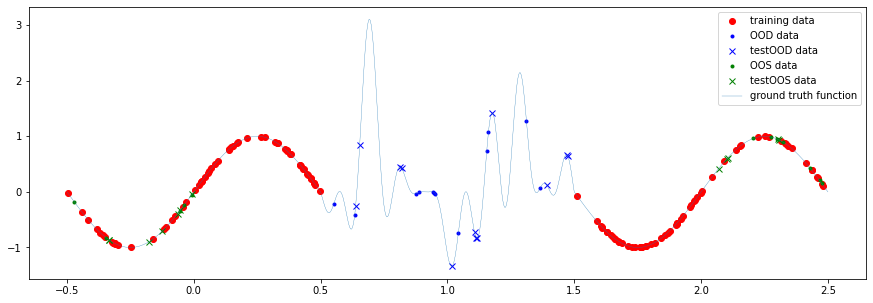

In [129]:
(x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test,
 oos_y_test, ood_x_test, ood_y_test, x_test, y_test) = generate_data(128, 24, 24, seed=7, plot=True)

full_X = torch.cat((x, ood_x, oos_x))
full_Y= torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

### one dropout value for each x

In [233]:
n_hidden = 128
hidden_layers = 4
lr = 1e-3

logit = [nn.Parameter(torch.tensor(-.5)), nn.Parameter(torch.tensor(-.5)),
           nn.Parameter(torch.tensor(-.5)), nn.Parameter(torch.tensor(-.5))]
shared_layers = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU())
noise_generator = [nn.Sequential(shared_layers, nn.Linear(32, n_hidden)),
                   nn.Sequential(shared_layers, nn.Linear(32, n_hidden)),
                   nn.Sequential(shared_layers, nn.Linear(32, n_hidden)),
                   nn.Sequential(shared_layers, nn.Linear(32, n_hidden))]
# noise_generator = [nn.Sequential(shared_layers, nn.Linear(32, 1)),
#                    nn.Sequential(shared_layers, nn.Linear(32, 1)),
#                    nn.Sequential(shared_layers, nn.Linear(32, 1)),
#                    nn.Sequential(shared_layers, nn.Linear(32, 1))]
                  
model = Model(n_hidden=n_hidden, hidden_layers=hidden_layers,
                              dropout_module=RegularDropoutPerLayer, tau=1, logit=logit,
                              noise_generator=noise_generator)
print([x[0] for x in model.named_parameters()])

def eval_model(model):
    def eval_at(x):
        return torch.cat([model.model.dropout1.noise_generator(x).mean(0),
                      model.model.dropout2.noise_generator(x).mean(0),
                      model.model.dropout3.noise_generator(x).mean(0),
                      model.model.dropout4.noise_generator(x).mean(0)]).mean()
    return eval_at(x).item(), eval_at(ood_x).item()
eval_model(model)

['model.hidden_layer1.weight', 'model.hidden_layer1.bias', 'model.dropout1.logit', 'model.dropout1.noise_generator.0.0.weight', 'model.dropout1.noise_generator.0.0.bias', 'model.dropout1.noise_generator.0.2.weight', 'model.dropout1.noise_generator.0.2.bias', 'model.dropout1.noise_generator.1.weight', 'model.dropout1.noise_generator.1.bias', 'model.hidden_layer2.weight', 'model.hidden_layer2.bias', 'model.dropout2.logit', 'model.dropout2.noise_generator.1.weight', 'model.dropout2.noise_generator.1.bias', 'model.hidden_layer3.weight', 'model.hidden_layer3.bias', 'model.dropout3.logit', 'model.dropout3.noise_generator.1.weight', 'model.dropout3.noise_generator.1.bias', 'model.hidden_layer4.weight', 'model.hidden_layer4.bias', 'model.dropout4.logit', 'model.dropout4.noise_generator.1.weight', 'model.dropout4.noise_generator.1.bias', 'model.output_layer.weight', 'model.output_layer.bias']


(0.008856343217839348, 0.00814563636614133)

In [234]:
optimizer = torch.optim.Adam([y for x, y in model.named_parameters() if 'dropout' not in x], lr=lr)
losses, valid_losses = train_main_model(model, optimizer, TensorDataset(x, y), TensorDataset(oos_x, oos_y),
                                       epochs=500, batch_size=32)

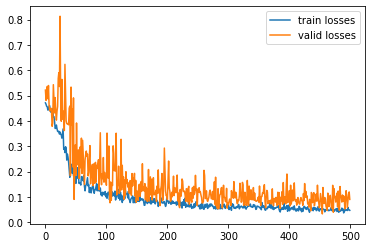

In [235]:
plt.plot(losses, label='train losses')
plt.plot(valid_losses, label='valid losses')
plt.legend()

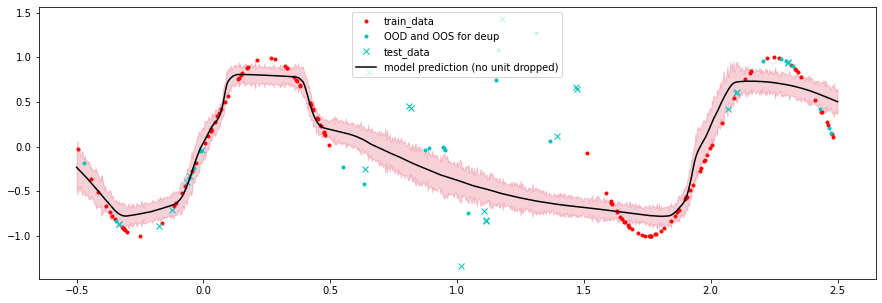

error on train data for deup (before training): 0.1447460521615394
error on train data for deup excluding train (before training): 0.893648699241031
error on test data for deup (before training): 0.9096882401614694


In [236]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True,
                  parametric_noise=False, x_input=True, n_samples=20)
print('error on train data for deup (before training):', 
      eval_error(model, full_X, full_Y,
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on train data for deup excluding train (before training):', 
      eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y)),
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on test data for deup (before training):', 
      eval_error(model, test_data[:][0], test_data[:][1],
                 n_samples=20, parametric_noise=False, x_input=True).item())

In [230]:
params = [y for x, y in model.named_parameters() if 'noise_generator' in x]
print([x for x, y in model.named_parameters() if 'noise_generator' in x])
optimizer = torch.optim.Adam(params, lr=1e-3)
losses, callbacks = train_deup(model, optimizer, full_data, epochs=500, batch_size=4, n_samples=5,
                    parametric_noise=True, x_input=True, callback=eval_model)

['model.dropout1.noise_generator.0.0.weight', 'model.dropout1.noise_generator.0.0.bias', 'model.dropout1.noise_generator.0.2.weight', 'model.dropout1.noise_generator.0.2.bias', 'model.dropout1.noise_generator.1.weight', 'model.dropout1.noise_generator.1.bias', 'model.dropout2.noise_generator.1.weight', 'model.dropout2.noise_generator.1.bias', 'model.dropout3.noise_generator.1.weight', 'model.dropout3.noise_generator.1.bias', 'model.dropout4.noise_generator.1.weight', 'model.dropout4.noise_generator.1.bias']


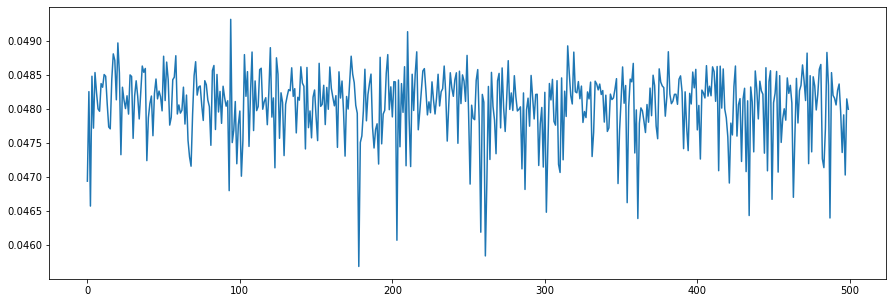

In [231]:
plt.figure(figsize=(15, 5))
plt.plot(losses)

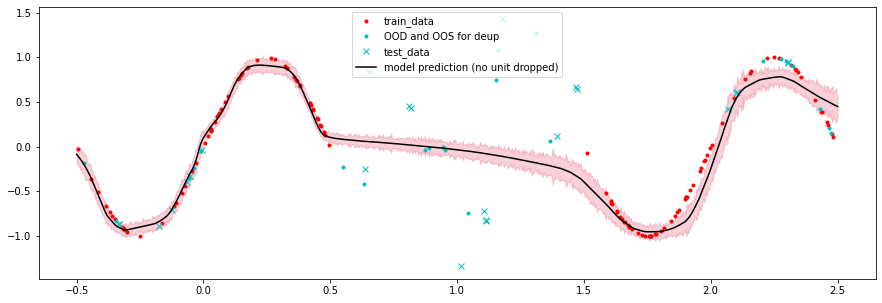

error on train data for deup (after training): 0.04779916979020856
error on train data for deup excluding train (after training): 0.2949866139613838
error on test data for deup (after training): 0.4657051294264393


In [232]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True, parametric_noise=True, x_input=True, n_samples=20)
print('error on train data for deup (after training):', 
      eval_error(model, full_X, full_Y,
                 n_samples=20, parametric_noise=True, x_input=True).item())
print('error on train data for deup excluding train (after training):', 
      eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y)),
                 n_samples=20, parametric_noise=True, x_input=True).item())
print('error on test data for deup (after training):', 
      eval_error(model, test_data[:][0], test_data[:][1],
                 n_samples=20, parametric_noise=True, x_input=True).item())

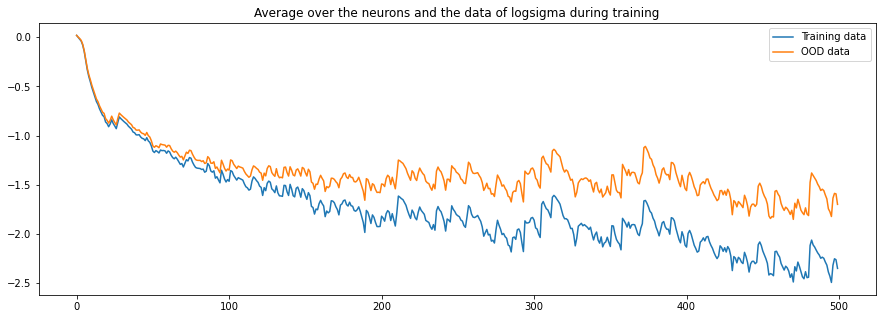

In [224]:
plt.figure(figsize=(15, 5))
plt.plot([callback[0] for callback in callbacks], label='Training data')
plt.plot([callback[1] for callback in callbacks], label='OOD data')
plt.title('Average over the neurons and the data of logsigma during training')
plt.legend()
plt.show()

### Same but with neuronwise dropout

In [123]:
n_hidden = 128
hidden_layers = 4
lr = 1e-3

logsigma = nn.Parameter(torch.tensor(-1.))
noise_generator = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, n_hidden))
                  
model = Model(n_hidden=n_hidden, hidden_layers=hidden_layers,
                              dropout_module=MultiplicativeGaussian, mu=None, logsigma=logsigma,
                              noise_generator=noise_generator)
print([x[0] for x in model.named_parameters()])
optimizer = torch.optim.Adam([y for x, y in model.named_parameters() if 'dropout' not in x], lr=lr)
losses, valid_losses = train_main_model(model, optimizer, TensorDataset(x, y), TensorDataset(oos_x, oos_y),
                                       epochs=500, batch_size=32)

['model.hidden_layer1.weight', 'model.hidden_layer1.bias', 'model.dropout1.mu', 'model.dropout1.logsigma', 'model.dropout1.noise_generator.0.weight', 'model.dropout1.noise_generator.0.bias', 'model.dropout1.noise_generator.2.weight', 'model.dropout1.noise_generator.2.bias', 'model.dropout1.noise_generator.4.weight', 'model.dropout1.noise_generator.4.bias', 'model.hidden_layer2.weight', 'model.hidden_layer2.bias', 'model.dropout2.mu', 'model.hidden_layer3.weight', 'model.hidden_layer3.bias', 'model.dropout3.mu', 'model.hidden_layer4.weight', 'model.hidden_layer4.bias', 'model.dropout4.mu', 'model.output_layer.weight', 'model.output_layer.bias']


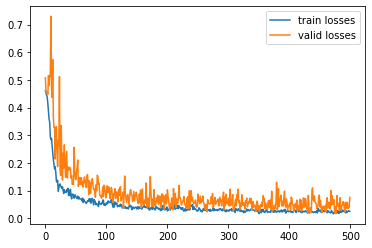

In [124]:
plt.plot(losses, label='train losses')
plt.plot(valid_losses, label='valid losses')
plt.legend()

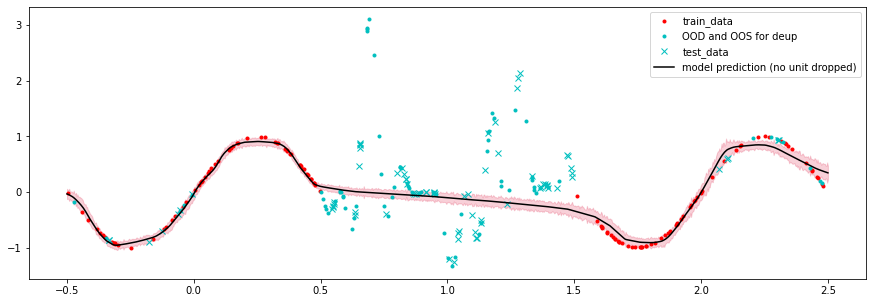

error on train data for deup (before training): 1.944940595294152
error on train data for deup excluding train (before training): 5.168788037950943
error on test data for deup (before training): 1.207798816232179


In [125]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True,
                  parametric_noise=False, x_input=True, n_samples=20)
print('error on train data for deup (before training):', 
      eval_error(model, full_X, full_Y,
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on train data for deup excluding train (before training):', 
      eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y)),
                 n_samples=20, parametric_noise=False, x_input=True).item())
print('error on test data for deup (before training):', 
      eval_error(model, test_data[:][0], test_data[:][1],
                 n_samples=20, parametric_noise=False, x_input=True).item())

In [126]:
params = [y for x, y in model.named_parameters() if 'noise_generator' in x]
print([x for x, y in model.named_parameters() if 'noise_generator' in x])
optimizer = torch.optim.Adam(params, lr=1e-3)
losses = train_deup(model, optimizer, full_data, epochs=500, batch_size=32, n_samples=5, parametric_noise=True, x_input=True)

['model.dropout1.noise_generator.0.weight', 'model.dropout1.noise_generator.0.bias', 'model.dropout1.noise_generator.2.weight', 'model.dropout1.noise_generator.2.bias', 'model.dropout1.noise_generator.4.weight', 'model.dropout1.noise_generator.4.bias']


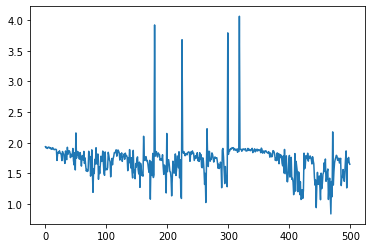

In [127]:
plt.plot(losses)

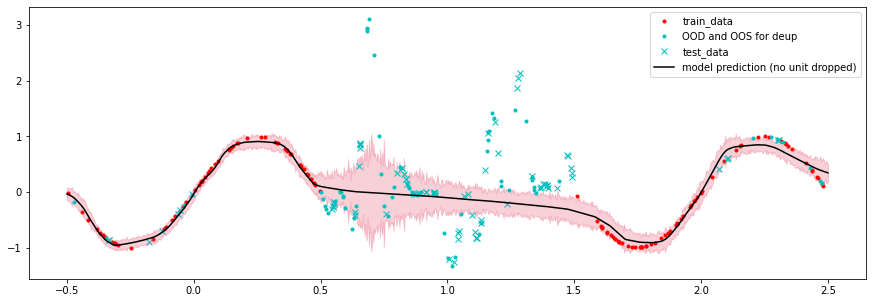

error on train data for deup (after training): 1.6130625949051056
error on train data for deup excluding train (after training): 3.82364434808902
error on test data for deup (after training): 1.1554841621814906


In [128]:
evaluate_and_plot(model, x_test, x, y, oos_ood, test_data, deup=True, parametric_noise=True, x_input=True, n_samples=20)
print('error on train data for deup (after training):', 
      eval_error(model, full_X, full_Y,
                 n_samples=20, parametric_noise=True, x_input=True).item())
print('error on train data for deup excluding train (after training):', 
      eval_error(model, torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y)),
                 n_samples=20, parametric_noise=True, x_input=True).item())
print('error on test data for deup (after training):', 
      eval_error(model, test_data[:][0], test_data[:][1],
                 n_samples=20, parametric_noise=True, x_input=True).item())